# Part - II
## Clustering Techniques
* This notebook contains KMeans Clustering.
* The connecting notebook contains Agglomerative Clustering & DBSCAN.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, GlobalMaxPooling2D, UpSampling2D
from tensorflow.keras.layers import BatchNormalization
from sklearn.model_selection import train_test_split
import cv2

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.neighbors import NearestNeighbors
import zipfile

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# https://drive.google.com/file/d/1VT-8w1rTT2GCE5IE5zFJPMzv7bqca-Ri/view?usp=sharing

with zipfile.ZipFile("/content/drive/My Drive/dataset.zip","r") as zip_ref:
  zip_ref.extractall()

In [ ]:
from PIL import Image
import os
import shutil

data = []

path = 'dataset/'
for i in os.listdir(path = path):
  data.append(path + str(i))

print(len(data))

4738


In [ ]:
data[:5]

['dataset/3064.jpg',
 'dataset/2195.jpg',
 'dataset/4366.jpg',
 'dataset/1748.jpg',
 'dataset/3803.jpg']

## Model Import & Feature Extraction
* The saved model is imported and loaded into the notebook model1.
* The feature at the bottom of the Encoder which is at Layer 6 from bottom of the model is considered, then flattened and then extracted as a vector.
* The vectors are very big which is 262144 dimension vector hence another MaxPool Layer was added and vectors are extracted at 65536 dimentions.
* Tried all kinds of architecture to reduce the dimensions to 32 filters (32, 32, 32 and 64, 64, 32 and 32, 32, 64) and 16 filters too but results were not good as the speckle from the image is removed but the image enhancement/reconstruction was worse and may be giving out bad results.



In [ ]:
import tensorflow as tf
model = tf.keras.models.load_model('/content/drive/My Drive/model3.h5')

In [ ]:
model1 = Sequential()
model1.add(Model(model.input, model.layers[-6].output))
model1.add(MaxPooling2D((2,2), padding='same', name='MPool1'))
model1.add(Flatten())
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_1 (Functional)    (None, 64, 64, 64)        78144     
_________________________________________________________________
MPool1 (MaxPooling2D)        (None, 32, 32, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 65536)             0         
Total params: 78,144
Trainable params: 77,760
Non-trainable params: 384
_________________________________________________________________


## Feature Extraction
* The image features are extracted from bottom of encoder but the vector is very high dimension.
* The Train data is 4480 image vectors which are appx 95% of the data.
* For cross validation, 128 image vectors are considered.
* A dataframe is also shown for the reference purpose.

In [ ]:
def load_images(path):
  image_list = []
  for i in path:
    img = cv2.imread(i)
    img = cv2.resize(img, (256, 256))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img/255.
    image_list.append(img)
  return image_list

In [ ]:

images = load_images(data[:4480])
images = np.array(images)

feats = []
for image in images:
  img = np.expand_dims(image, axis = 0)
  features = model1(img)
  features = np.reshape(features, (features.shape[1]))
  feats.append(features)


In [ ]:
df = pd.DataFrame(data = np.array(feats[:10]))
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,65496,65497,65498,65499,65500,65501,65502,65503,65504,65505,65506,65507,65508,65509,65510,65511,65512,65513,65514,65515,65516,65517,65518,65519,65520,65521,65522,65523,65524,65525,65526,65527,65528,65529,65530,65531,65532,65533,65534,65535
0,-0.625735,-0.636934,-1.076464,1.468723,0.188565,-0.680806,-0.508686,0.437042,-0.309003,-0.870483,-0.780207,-0.972128,3.302361,-0.414794,-1.188476,4.560752,3.328112,0.039214,-0.660951,-0.547691,-0.490745,-0.604662,-0.569761,1.233253,-0.419993,-1.007569,-0.355196,-0.904761,-0.512037,-0.889914,0.532936,0.568920,-0.601009,3.116104,-0.851251,-0.940096,-0.790701,0.842076,-0.078590,-0.793865,...,-0.537801,-0.552205,-0.355196,-0.973247,-0.438818,-0.889914,0.278957,0.927687,-0.601009,2.494889,-0.618905,-0.940096,-0.790701,2.477389,-0.419177,-0.793865,-0.624747,0.947918,4.144691,2.828281,-0.331019,-1.161540,-0.470024,0.130673,-0.587669,-1.092289,4.091671,-0.761939,1.190702,1.135121,-0.627425,0.272033,-0.043518,4.675490,-0.678225,-1.182384,-0.584771,-0.702323,2.359077,-1.079394
1,0.025469,-0.636934,-0.592252,-0.545149,1.430094,0.309995,0.125641,0.366037,-0.497567,0.031031,0.317566,-0.448903,0.437343,-0.613108,-0.616357,-0.144784,-0.164822,0.353758,-0.223086,-0.606829,0.163227,-0.423718,-0.111809,2.275275,0.433200,-0.446094,-0.326760,-0.794542,-0.368226,-0.480554,-0.623522,1.518218,-0.104714,0.517763,-0.340852,-0.284320,-0.076019,-0.568163,0.490549,-0.585109,...,-0.504710,-0.597367,-0.355196,-0.908419,-0.410177,-0.889914,0.209059,0.846505,-0.601009,2.201962,-0.851251,-0.916865,-0.790701,1.683088,-0.542446,-0.793865,-0.624747,3.293533,3.552897,2.692883,-0.303321,-1.184310,-0.470024,-0.189978,-0.587669,-1.092289,4.209617,-0.758963,0.981814,0.902272,-0.627425,0.165958,-0.043518,4.945086,-0.678225,-1.288949,-0.584771,-0.754286,1.399784,-1.079394
2,-0.623281,-0.636934,-1.076464,0.547905,0.137103,-0.291943,-0.273496,-0.190808,-0.270338,-0.691967,-0.739411,-1.182466,2.947623,-0.644640,-1.188476,2.714583,3.008503,0.347147,-0.660951,-0.606829,-0.251890,-0.543692,-0.437606,0.122728,-0.318840,-1.007569,-0.355196,-0.973247,-0.512037,-0.889914,-0.143796,0.360407,-0.601009,2.571828,-0.851251,-0.889728,-0.790701,0.141710,-0.175172,-0.793865,...,-0.463392,-0.600350,-0.355196,-0.973247,-0.475215,-0.889914,-0.179261,0.714791,-0.601009,2.798078,-0.851251,-0.940096,-0.790701,1.234464,-0.545533,-0.793865,-0.624747,4.046479,3.515486,2.272374,-0.362091,-1.184310,-0.470024,-0.357382,-0.587669,-1.092289,3.941706,-0.761939,0.977197,0.496778,-0.627425,0.053513,-0.043518,4.619093,-0.678225,-1.288949,-0.584771,-0.789318,1.097862,-1.079394
3,-0.512198,-0.636934,-1.076464,0.345052,0.079153,-0.403755,-0.371505,0.048539,-0.418888,-0.747312,-0.715710,-1.112512,2.942194,-0.527598,-1.188476,2.933140,1.583004,0.129502,-0.660951,-0.606829,-0.397616,-0.604662,-0.417078,0.708489,-0.164623,-1.007569,-0.355196,-0.973247,-0.512037,-0.889914,-0.296889,0.139336,-0.601009,3.195768,-0.851251,-0.871114,-0.790701,-0.008781,-0.142349,-0.793865,...,-0.662634,0.009286,-0.355196,-0.548229,-0.446879,-0.660853,0.060111,0.337237,-0.244566,4.230799,-0.642058,-0.641912,-0.470398,2.005919,-0.147961,-0.453169,-0.447898,1.767448,5.701807,2.041008,-0.142450,-0.950953,-0.470024,-0.027171,-0.587669,-1.092289,3.639782,-0.409256,2.439784,0.545258,-0.627425,0.240637,-0.043518,4.183057,-0.678225,-1.010588,-0.584771,-0.803527,2.328015,-1.079394
4,-0.542088,-0.636934,-1.076464,1.230626,0.198080,-0.326135,-0.416281,0.037565,-0.127155,-0.738963,-0.738848,-1.149471,3.353110,-0.644640,-1.188476,3.949297,3.703770,0.413865,-0.660951,-0.606829,-0.091847,-0.473533,-0.516822,-0.060042,-0.374379,-1.007569,-0.355196,-0.973247,-0.512037,-0.889914,0.434848,0.670200,-0.601009,1.850602,-0.851251,-0.940096,-0.790701,0.765131,-0.219246,-0.793865,...,-0.546008,-0.270389,-0.355196,-0.614975,-0.512037,-0.645699,-0.623522,0.401415,-0.444967,0.386450,-0.615765,-0.609397,-0.41984

## Image Standardizing / Normalizing
* After many experiments, Normalizing the image is giving good results than standardizing of images.
* Train vectors of 4000 and CV vectors of 128 are Normalized using MinMaxScalar.
* This step is required for easy convergernce and fast running of algorithm. And most importantly due to the high contrast, the image pixels at some places are large and hence bringing all to one scale.

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

min_max_scaler = MinMaxScaler()
feats_scaled = min_max_scaler.fit_transform(feats)
feats_scaled.shape

(4480, 65536)

In [ ]:
images = load_images(data[4480:4608])
images = np.array(images)

feats_cv = []
for image in images:
  img = np.expand_dims(image, axis = 0)
  features = model1(img)
  features = np.reshape(features, (features.shape[1]))
  feats_cv.append(features)


In [ ]:
feats_scaled_cv = min_max_scaler.fit_transform(feats_cv)
df_cv = pd.DataFrame(feats_scaled_cv)
df_cv['images'] = data[4480:4608]
df_cv.shape

(128, 65537)

In [ ]:
cols = list(df_cv.columns)
cols = [cols[-1]] + cols[:-1]
df_cv = df_cv[cols]
df_cv.head()

,images,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,65496,65497,65498,65499,65500,65501,65502,65503,65504,65505,65506,65507,65508,65509,65510,65511,65512,65513,65514,65515,65516,65517,65518,65519,65520,65521,65522,65523,65524,65525,65526,65527,65528,65529,65530,65531,65532,65533,65534,65535
0,dataset/1635.jpg,0.073779,0.0,0.0000,0.540791,0.165716,0.124888,0.000000,0.317220,0.518380,0.000066,0.000000,0.000000,0.664707,0.0,0.000000,0.753483,0.534581,0.396916,0.0,0.000000,0.426518,0.147768,0.097954,0.000000,0.036512,0.000000,0.0,0.000000,0.0,0.000000,0.793699,0.361728,0.000000,0.245091,0.000000,0.000000,0.000000,0.561755,0.256317,...,0.114928,0.307309,0.0,0.287131,0.000000,0.021963,0.121851,0.263405,0.075809,0.175556,0.008782,0.029233,0.076953,0.181494,0.062518,0.153268,0.034925,0.350214,0.312679,0.576665,0.224082,0.195184,0.0,0.110090,0.0,0.0,0.372715,0.193671,0.127813,0.083168,0.0,0.124084,0.0,0.645433,0.0,0.048936,0.0,0.246912,0.175432,0.000000
1,dataset/1845.jpg,0.588983,0.0,0.6853,0.109416,0.927667,0.582136,0.447170,0.492627,0.000000,0.738734,0.724066,0.798662,0.284366,0.0,0.626249,0.170918,0.134695,0.393442,1.0,0.000000,0.708347,0.258470,0.745992,0.162137,0.590784,0.621237,0.0,0.203124,0.0,0.540274,0.156378,0.571395,0.839476,0.050270,0.524800,0.679419,0.655188,0.045871,0.497731,...,0.429961,0.185562,0.0,0.770632,0.000000,0.000000,0.559034,0.466715,0.452495,0.285484,0.000000,0.129453,0.000000,0.582907,0.255061,0.573359,0.000000,0.000000,0.753257,0.895400,0.457739,0.194818,0.0,0.436717,0.0,0.0,0.598613,0.861662,0.469781,0.739444,0.0,0.274625,0.0,0.670552,0.0,0.020830,0.0,0.568240,0.446191,0.314565
2,dataset/3104.jpg,0.324904,0.0,0.0000,0.599136,0.289644,0.224577,0.564769,0.503248,0.828502,0.096948,0.000000,0.000000,0.756979,0.0,0.000000,0.791589,0.675474,0.532286,0.0,0.000000,0.327890,0.205021,0.000000,0.430017,0.172960,0.183151,0.0,0.000000,0.0,0.000000,0.820121,0.442063,0.000000,0.757628,0.207616,0.000000,0.000000,0.871442,0.496269,...,0.219148,0.385150,0.0,0.000000,0.800119,0.000000,0.306431,0.416920,0.000000,0.751366,0.584524,0.000000,0.000000,0.852801,0.294883,0.000000,0.000000,0.648134,0.993162,0.708984,0.195838,0.000000,0.0,0.523263,0.0,0.0,0.884724,0.000000,0.111215,0.493527,0.0,0.500801,0.0,0.911072,0.0,0.367390,0.0,0.175973,0.838535,0.000000
3,dataset/2082.jpg,0.168957,0.0,0.0000,0.653415,0.382764,0.175973,0.179080,0.594249,0.684867,0.049157,0.175686,0.292459,0.743904,0.0,0.000000,0.893742,0.616516,0.628776,0.0,0.125774,0.410901,0.235391,0.000000,0.056716,0.037361,0.432293,0.0,0.000000,0.0,0.000000,0.877533,0.611994,0.000000,0.263094,0.000000,0.000000,0.000000,0.600651,0.386630,...,0.156743,0.522946,0.0,0.079576,0.528110,0.000000,0.397693,0.434722,0.000000,0.495832,0.483316,0.000000,0.000000,0.948357,0.357390,0.000000,0.000000,0.278475,0.958031,0.754335,0.179723,0.351526,0.0,0.500451,0.0,0.0,0.731620,0.000000,0.170014,0.553935,0.0,0.407569,0.0,0.870172,0.0,0.295770,0.0,0.333795,0.781511,0.000000
4,dataset/432.jpg,0.486517,0.0,0.0000,0.614669,0.194945,0.000000,0.048255,0.310506,0.654202,0.023217,0.000000,0.000000,0.682603,0.0,0.000000,0.984190,0.972254,0.306612,0.0,0.000000,0.090137,0.000000,0.000000,1.000000,0.000000,0.495366,0.0,0.000000,0.0,0.000000,0.700431,0.270767,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.505529,...,0.273906,0.440844,0.0,0.000000,0.910670,0.000000,0.368061,0.433778,0.000000,0.649742,0.372847,0.000000,0.000000,0.890517,0.268011,0.000000,0.000000,0.657557,0.920967,0.709726,0.166991,0.000000,0.0,0.575330,0.0,0.0,0.877726,0.000000,0.048148,0.456663,0.0,0.466022,0.0,0.912316,0.0,0.134339,0.0,0.091745,0.773153,0.000000


## KMeans Clustering Technique
* The KMeans algorithm clusters data by trying to separate samples in n groups of equal variance, minimizing a criterion known as the inertia or within-cluster sum-of-squares. 
* This algorithm requires the number of clusters to be specified and which is also a hyperparameter. I have tried 5, 10, 15, 20 clusters and optimum cluster is 10.
* The optimum cluster is found out based on  Elbow method.
* The random state used is 18 and can be re-initialized again to get same results.
* The initialization used is 'KMeans++' and the centroid initializations are 100. The number can go upto 10000 also but due to limited resources I have capped the limit to 100.


100%|██████████| 4/4 [6:10:57<00:00, 5564.43s/it]


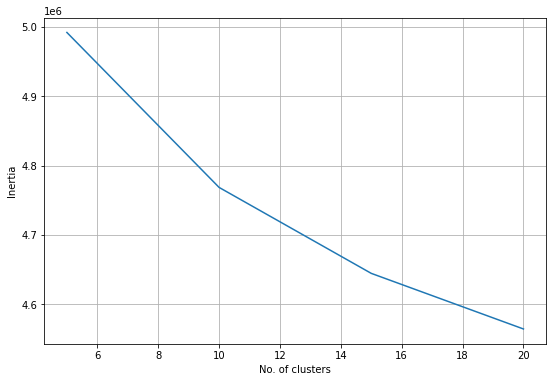

In [ ]:
from tqdm import tqdm

inertia = []
k = list(range(5, 25, 5))

for i in tqdm(k):
  km = KMeans(n_clusters = i, n_init= 100, random_state= 18).fit(feats_scaled)
  inertia.append(km.inertia_)

plt.figure(figsize = (9, 6))
plt.grid()
plt.plot(k, inertia)
plt.xlabel('No. of clusters')
plt.ylabel('Inertia')
plt.show()

## Display of Clusters and their images

* The clusters 0, 4, 8 are giving good results.
* Zero cluster is clustered with 13 Tigers, 7 Cheetahs, 5 Jaguars, 1 Lion and 2 Wolves.
* Four cluster is clustered with 5 Lions and 1 Cheetah.
* Eight cluster is clustered with 12 Tigers and 7 Jaguars and 1 Lion.
* Rest of other clusters didnt gave good results.
* Here we can observe that Tigers and Jaguars are clustered together.
* Data Imbalancing might be the cause for this behaviour.

In [ ]:
km = KMeans(n_clusters = 10, n_init= 100, random_state= 18).fit_predict(df_cv[df_cv.columns[1:]])

In [ ]:
from collections import Counter

Counter(km)

Counter({0: 28, 1: 21, 2: 44, 3: 1, 4: 6, 5: 1, 6: 1, 7: 4, 8: 21, 9: 1})

In [ ]:
zero=[]
one=[]
two=[]
three=[]
four=[]
five=[]
six=[]
seven=[]
eight = []
nine=[]
ten=[]
eleven=[]
tweleve=[]
thirteen=[]
fourteen=[]

k = list(km)
for i in range(len(k)):
  if k[i] == 0:
    zero.append(i)
  elif k[i] == 1:
    one.append(i)
  elif k[i] == 2:
    two.append(i)
  elif k[i] == 3:
    three.append(i)
  elif k[i] == 4:
    four.append(i)
  elif k[i] == 5:
    five.append(i)
  elif k[i] == 6:
    six.append(i)
  elif k[i] == 7:
    seven.append(i)
  elif k[i] == 8:
    eight.append(i)
  elif k[i] == 9:
    nine.append(i)
  elif k[i] == 10:
    ten.append(i)
  elif k[i] == 11:
    eleven.append(i)
  elif k[i] == 12:
    tweleve.append(i)
  elif k[i] == 13:
    thirteen.append(i)
  else:
    fourteen.append(i)

### Cluster Zero

* Zero cluster is clustered with 13 Tigers, 7 Cheetahs, 5 Jaguars, 1 Lion and 2 Wolves.

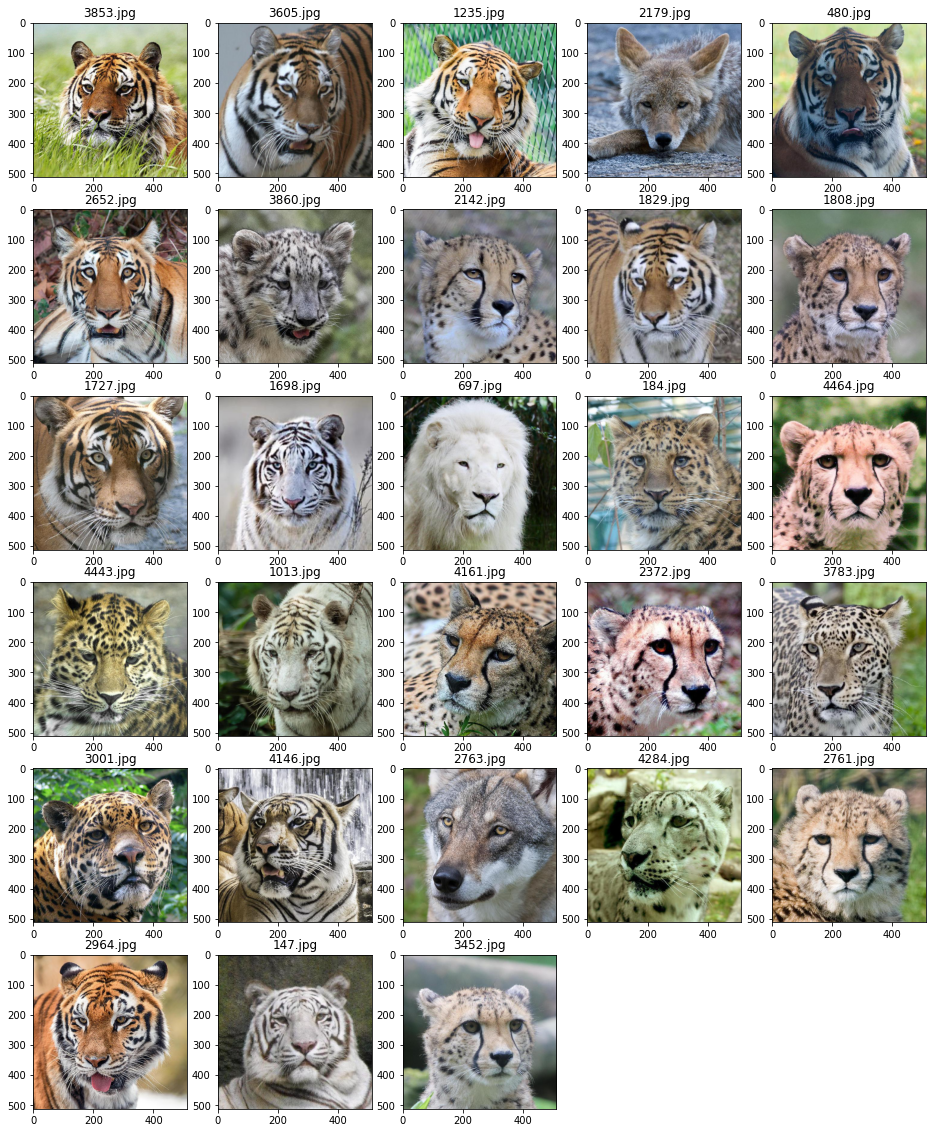

In [ ]:
pics = data[4480:4608]
plt.figure(figsize= (16, 20))
for j, i in enumerate(zero):
  # nrows = 2, ncols = 3, index = i + 1
  plt.subplot(6, 5, j + 1)
  img = plt.imread(pics[i])
  plt.imshow(img)
  j = pics[i]
  plt.title(j[len(path):])

plt.show()

### Cluster Four

* Four cluster is clustered with 5 Lions and 1 Cheetah.

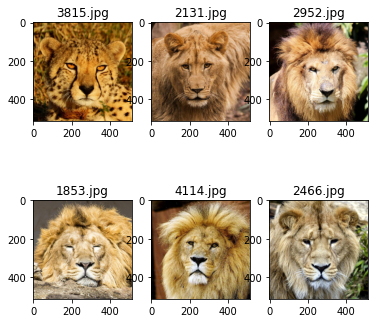

In [ ]:
plt.figure(figsize= (6, 6))
for j, i in enumerate(four):
  # nrows = 2, ncols = 3, index = i + 1
  plt.subplot(2, 3, j + 1)
  img = plt.imread(pics[i])
  plt.imshow(img)
  j = pics[i]
  plt.title(j[len(path):])

plt.show()

### Cluster Eight

* Eight cluster is clustered with 12 Tigers and 7 Jaguars and 1 Lion.

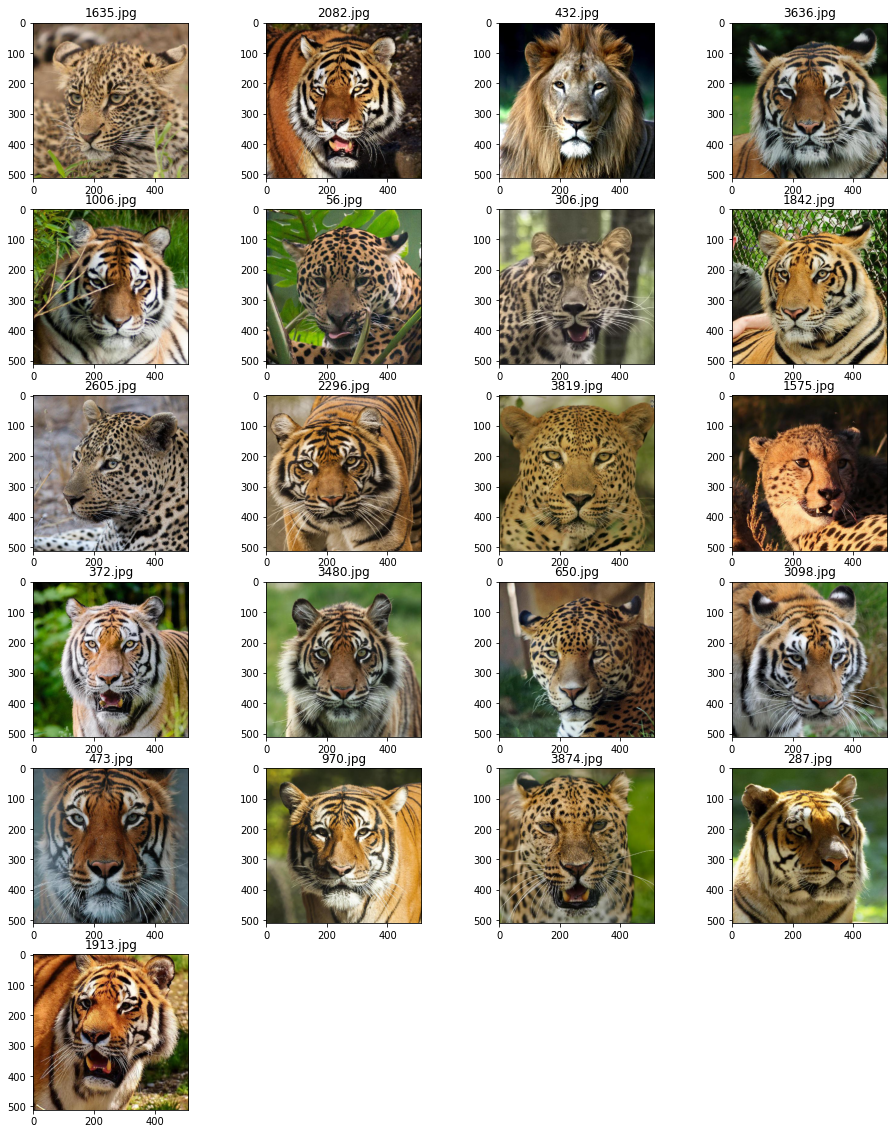

In [ ]:
plt.figure(figsize= (16, 20))
for j, i in enumerate(eight):
  # nrows = 2, ncols = 3, index = i + 1
  plt.subplot(6, 4, j + 1)
  img = plt.imread(pics[i])
  plt.imshow(img)
  j = pics[i]
  plt.title(j[len(path):])

plt.show()